In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

from mmocc import utils as mm_utils
from mmocc.config import (
    cache_path,
    figures_path,
    default_image_backbone,
    default_sat_backbone,
    limit_to_range,
    wildlife_insights_test_project_ids,
)

sns.set_theme(style="whitegrid")
metrics_path = cache_path / "domain_shift" / "domain_shift_metrics.csv"
fig_dir = figures_path / "domain_shift"
fig_dir.mkdir(parents=True, exist_ok=True)

metrics = pd.read_csv(metrics_path)
metrics["display_name"] = metrics["scientific_name"].fillna(metrics["common_name"])
metrics.head()

,taxon_id,taxon_idx,scientific_name,common_name,modality,train_count,test_count,feature_dim,pca_variance,mean_distance,...,frechet_distance,mmd_rbf,train_detection_rate,test_detection_rate,detection_rate_gap,detection_wasserstein,train_positive_site_fraction,test_positive_site_fraction,range_filter_applied,display_name
0,00804e75-09ef-44e5-8984-85e365377d47,1,Antilocapra americana,pronghorn,covariates,1500,1023,26,1.000000,3.004595,...,15.625378,0.108250,0.038235,0.019067,-0.019168,0.006546,0.041719,0.057674,True,Antilocapra americana
1,00804e75-09ef-44e5-8984-85e365377d47,1,Antilocapra americana,pronghorn,image,1500,1023,128,0.820329,5.529500,...,155.578342,0.015301,0.038235,0.019067,-0.019168,0.006546,0.041719,0.057674,True,Antilocapra americana
2,00804e75-09ef-44e5-8984-85e365377d47,1,Antilocapra americana,pronghorn,sat,1500,1023,64,1.000000,3.673197,...,39.120802,0.067112,0.038235,0.019067,-0.019168,0.006546,0.041719,0.057674,True,Antilocapra americana
3,07843615-e1fc-49d8-9821-fd1d7ff2e773,13,Dasypus novemcinctus,nine-banded armadillo,covariates,426,1252,26,1.000000,1.884986,...,10.060675,0.061377,0.087051,0.148844,0.061793,0.057052,0.220657,0.309105,True,Dasypus novemcinctus
4,07843615-e1fc-49d8-9821-fd1d7ff2e773,13,Dasypus novemcinctus,nine-banded armadillo,image,426,1252,128,0.851901,7.118601,...,196.165961,0.023900,0.087051,0.148844,0.061793,0.057052,0.220657,0.309105,True,Dasypus novemcinctus


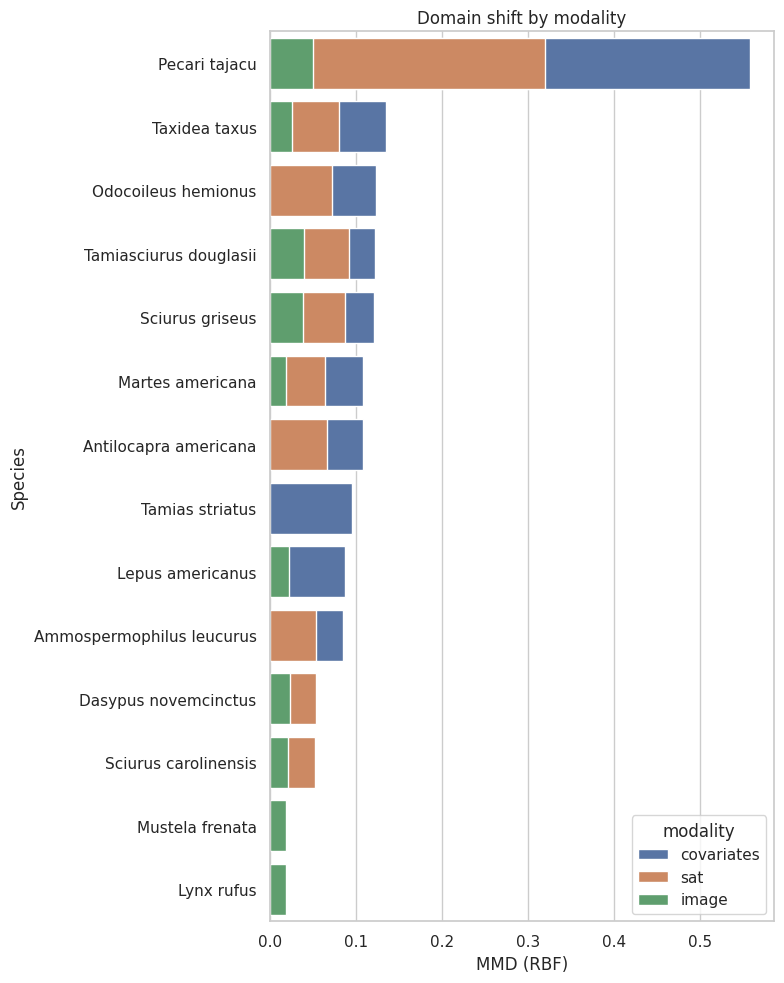

PosixPath('/data/vision/beery/scratch/timm/multimodal_occupancy/figures/domain_shift/domain_shift_top_mmd.png')

In [2]:
top_mmd = (
    metrics.sort_values("mmd_rbf", ascending=False).groupby("modality").head(10).copy()
)
plt.figure(figsize=(8, 10))
sns.barplot(data=top_mmd, x="mmd_rbf", y="display_name", hue="modality", dodge=False)
plt.xlabel("MMD (RBF)")
plt.ylabel("Species")
plt.title("Domain shift by modality")
plt.tight_layout()
top_path = fig_dir / "domain_shift_top_mmd.png"
plt.savefig(top_path, dpi=200)
plt.show()
plt.close()
top_path

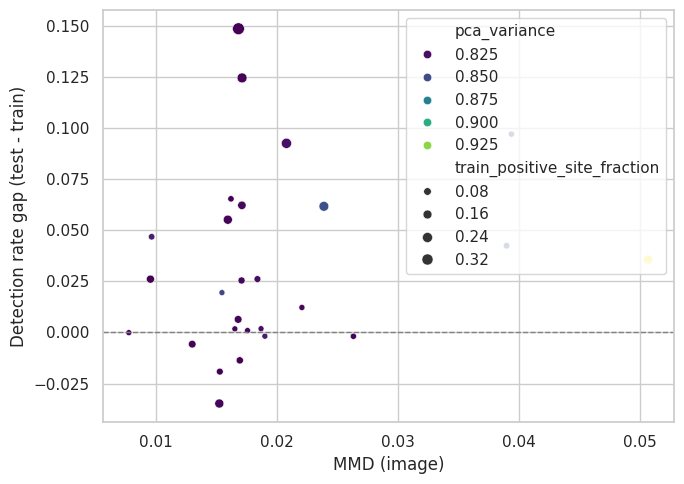

PosixPath('/data/vision/beery/scratch/timm/multimodal_occupancy/figures/domain_shift/detection_gap_vs_mmd.png')

In [3]:
image_mod = metrics[metrics["modality"] == "image"].copy()
plt.figure(figsize=(7, 5))
sns.scatterplot(
    data=image_mod,
    x="mmd_rbf",
    y="detection_rate_gap",
    size="train_positive_site_fraction",
    hue="pca_variance",
    palette="viridis",
    legend="brief",
)
plt.axhline(0, color="gray", linestyle="--", linewidth=1)
plt.xlabel("MMD (image)")
plt.ylabel("Detection rate gap (test - train)")
plt.tight_layout()
gap_path = fig_dir / "detection_gap_vs_mmd.png"
plt.savefig(gap_path, dpi=200)
plt.show()
plt.close()
gap_path

In [ ]:
from dataclasses import dataclass


@dataclass
class BaseData:
    species_map: pd.DataFrame
    taxon_map: dict[str, str]
    site_idx_all: np.ndarray
    mask_train: np.ndarray
    mask_test: np.ndarray
    latitudes: np.ndarray
    longitudes: np.ndarray
    features: dict[str, np.ndarray]
    conus_boundary: object | None
    result_array: np.memmap


def fill_missing(train: np.ndarray, test: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    combined = np.vstack([train, test])
    col_means = np.nanmean(combined, axis=0)
    col_means = np.where(np.isfinite(col_means), col_means, 0.0)
    return (
        np.where(np.isfinite(train), train, col_means),
        np.where(np.isfinite(test), test, col_means),
    )


def prepare_base_data(modalities: set[str], apply_range_filter: bool) -> BaseData:
    shape = tuple(
        np.loadtxt(cache_path / "wi_db_computer_vision_occupancy_y_shape.txt")
        .round()
        .astype(np.int64)
    )
    result_array = np.memmap(
        cache_path / "wi_db_computer_vision_occupancy_y.npy",
        dtype=np.float32,
        mode="r",
        shape=shape,
    )
    feature_path = cache_path / "features"
    ids_all = np.load(
        feature_path / f"wi_blank_image_features_{default_image_backbone}_ids.npy",
        allow_pickle=True,
    )
    image_features = np.load(
        feature_path / f"wi_blank_image_features_{default_image_backbone}.npy",
        allow_pickle=True,
    )
    sat_features = np.load(
        feature_path / f"wi_blank_sat_features_{default_sat_backbone}.npy",
        allow_pickle=True,
    )
    covariates = np.load(
        feature_path
        / f"wi_blank_image_features_{default_image_backbone}_covariates.npy",
        allow_pickle=True,
    )
    locs = np.load(
        feature_path / f"wi_blank_image_features_{default_image_backbone}_locs.npy",
        allow_pickle=True,
    )

    latitudes = locs[:, 0]
    longitudes = locs[:, 1]
    project_ids = np.array([e.split("___")[0] for e in ids_all])
    mask_test = np.array(
        [pid in wildlife_insights_test_project_ids for pid in project_ids]
    )
    mask_train = ~mask_test

    train_coords = np.column_stack([latitudes[mask_train], longitudes[mask_train]])
    test_coords = np.column_stack([latitudes[mask_test], longitudes[mask_test]])
    dist_matrix = mm_utils.get_dist_matrix(train_coords, test_coords)
    too_close = dist_matrix.min(axis=0) < 10
    mask_train[mask_train] &= ~too_close

    location_map_df = pd.read_csv(
        cache_path / "wi_db_computer_vision_location_map.csv",
        index_col="Project_Location",
    )
    species_map_df = pd.read_csv(cache_path / "wi_db_computer_vision_species_map.csv")
    site_idx_all = location_map_df["Location_Index"][ids_all].to_numpy()
    feature_bank = dict(image=image_features, sat=sat_features, covariates=covariates)
    features = {modality: feature_bank[modality] for modality in modalities}
    conus_boundary = mm_utils.get_conus_boundary() if apply_range_filter else None
    return BaseData(
        species_map=species_map_df,
        taxon_map=mm_utils.get_taxon_map(),
        site_idx_all=site_idx_all,
        mask_train=mask_train,
        mask_test=mask_test,
        latitudes=latitudes,
        longitudes=longitudes,
        features=features,
        conus_boundary=conus_boundary,
        result_array=result_array,
    )


def apply_range_mask(base: BaseData, scientific_name: str, common_name: str | None):
    mask_train = base.mask_train.copy()
    mask_test = base.mask_test.copy()
    if base.conus_boundary is None:
        return mask_train, mask_test

    name_final = scientific_name if scientific_name else common_name
    try:
        range_map = mm_utils.get_species_range_cached(name_final, admin_level="admin1")
        if range_map.crs != base.conus_boundary.crs:  # type: ignore[union-attr]
            range_map = range_map.to_crs(base.conus_boundary.crs)  # type: ignore[union-attr]
        range_map = gpd.overlay(range_map, base.conus_boundary, how="intersection")  # type: ignore[arg-type]
    except ValueError:
        range_map = base.conus_boundary

    train_points = gpd.points_from_xy(
        base.longitudes[mask_train], base.latitudes[mask_train]
    )
    train_gdf = gpd.GeoDataFrame(geometry=train_points, crs="EPSG:4326")
    if range_map.crs != train_gdf.crs:  # type: ignore[union-attr]
        range_map = range_map.to_crs(train_gdf.crs)  # type: ignore[union-attr]
    range_mask_train = train_gdf.intersects(range_map.union_all()).values  # type: ignore[arg-type]
    mask_train[mask_train] &= range_mask_train

    test_points = gpd.points_from_xy(
        base.longitudes[mask_test], base.latitudes[mask_test]
    )
    test_gdf = gpd.GeoDataFrame(geometry=test_points, crs="EPSG:4326")
    if range_map.crs != test_gdf.crs:  # type: ignore[union-attr]
        range_map = range_map.to_crs(test_gdf.crs)  # type: ignore[union-attr]
    range_mask_test = test_gdf.intersects(range_map.union_all()).values  # type: ignore[arg-type]
    mask_test[mask_test] &= range_mask_test
    return mask_train, mask_test


def get_split_features(
    base: BaseData, taxon_id: str, modalities: list[str], apply_range: bool
):
    species_row = base.species_map.loc[base.species_map["WI_taxon_id"] == taxon_id]
    if species_row.empty:
        return None
    taxon_idx = int(species_row["Species_Index"].values[0])
    scientific_name = species_row["Scientific_Name"].values[0]
    common_name = base.taxon_map.get(taxon_id)
    mask_train, mask_test = (
        apply_range_mask(base, scientific_name, common_name)
        if apply_range
        else (base.mask_train.copy(), base.mask_test.copy())
    )
    splits = {}
    for modality in modalities:
        feats = base.features[modality]
        train = feats[mask_train]
        test = feats[mask_test]
        splits[modality] = fill_missing(train, test)
    return dict(
        scientific_name=scientific_name,
        common_name=common_name,
        splits=splits,
    )


def run_tsne(
    train: np.ndarray,
    test: np.ndarray,
    max_samples: int = 800,
    pca_components: int = 50,
    random_state: int = 0,
) -> pd.DataFrame:
    rng = np.random.default_rng(random_state)
    if max_samples and train.shape[0] > max_samples:
        train = train[rng.choice(train.shape[0], max_samples, replace=False)]
    if max_samples and test.shape[0] > max_samples:
        test = test[rng.choice(test.shape[0], max_samples, replace=False)]

    train, test = fill_missing(train, test)
    combined = np.vstack([train, test]).astype(np.float32)
    combined = StandardScaler().fit_transform(combined)
    if pca_components and combined.shape[1] > pca_components:
        n_comp = min(pca_components, combined.shape[1], max(2, combined.shape[0] - 1))
        combined = PCA(n_components=n_comp, random_state=random_state).fit_transform(
            combined
        )

    total = combined.shape[0]
    perplexity = max(5, min(30, total // 3))
    tsne = TSNE(
        n_components=2,
        perplexity=perplexity,
        random_state=random_state,
        init="pca",
        learning_rate="auto",
    )
    embedding = tsne.fit_transform(combined)
    labels = ["train"] * train.shape[0] + ["test"] * test.shape[0]
    return pd.DataFrame({"x": embedding[:, 0], "y": embedding[:, 1], "split": labels})

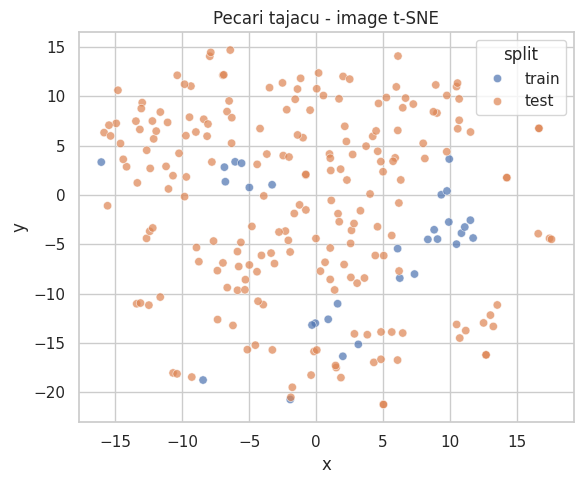

/data/vision/beery/scratch/timm/multimodal_occupancy/figures/domain_shift/tsne_pecari_tajacu_image.png


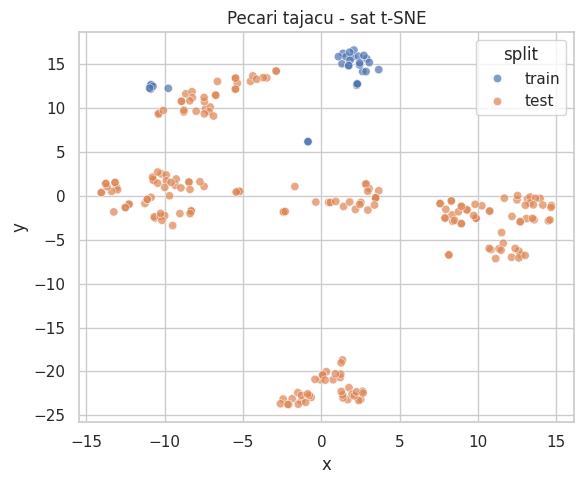

/data/vision/beery/scratch/timm/multimodal_occupancy/figures/domain_shift/tsne_pecari_tajacu_sat.png


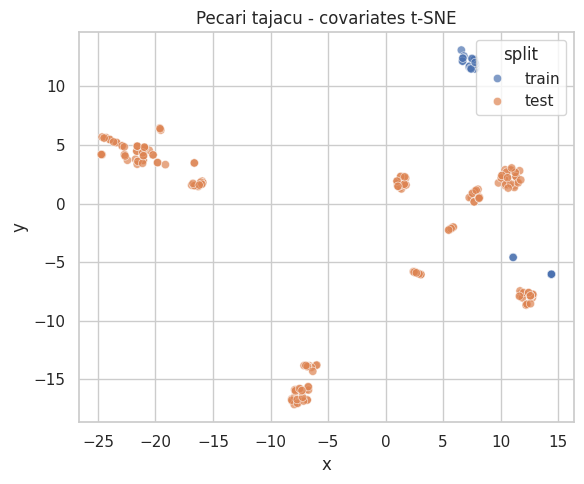

/data/vision/beery/scratch/timm/multimodal_occupancy/figures/domain_shift/tsne_pecari_tajacu_covariates.png


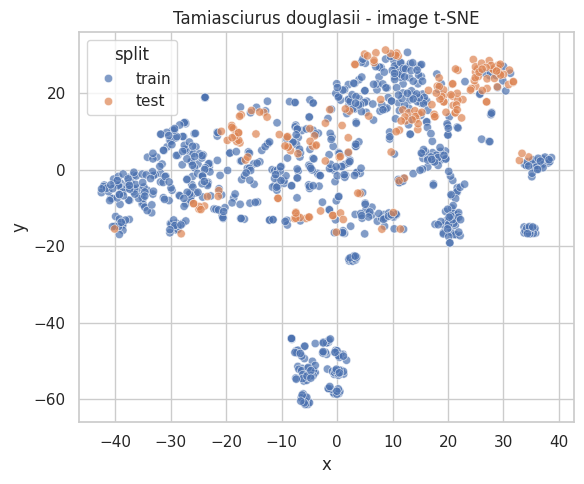

/data/vision/beery/scratch/timm/multimodal_occupancy/figures/domain_shift/tsne_tamiasciurus_douglasii_image.png


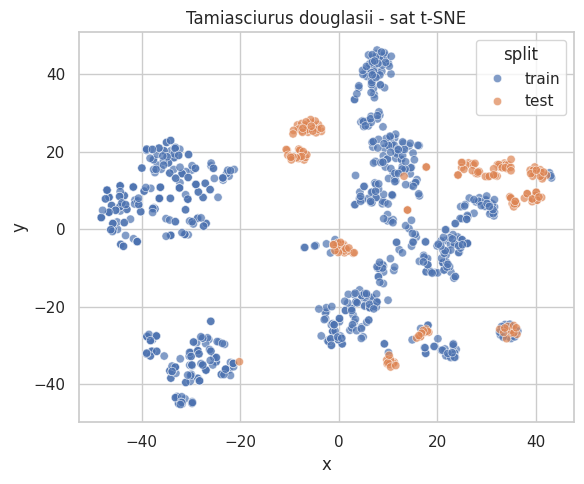

/data/vision/beery/scratch/timm/multimodal_occupancy/figures/domain_shift/tsne_tamiasciurus_douglasii_sat.png


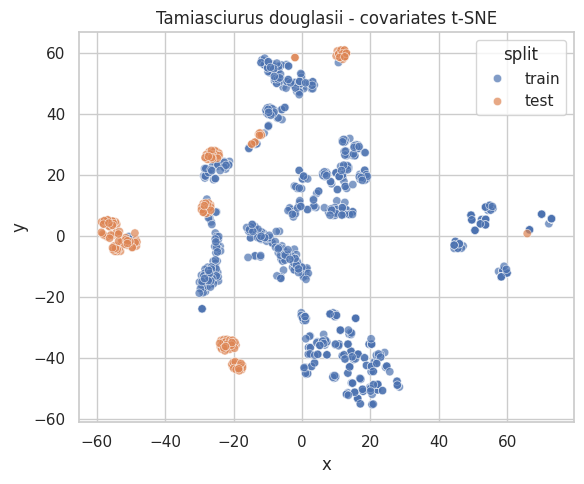

/data/vision/beery/scratch/timm/multimodal_occupancy/figures/domain_shift/tsne_tamiasciurus_douglasii_covariates.png


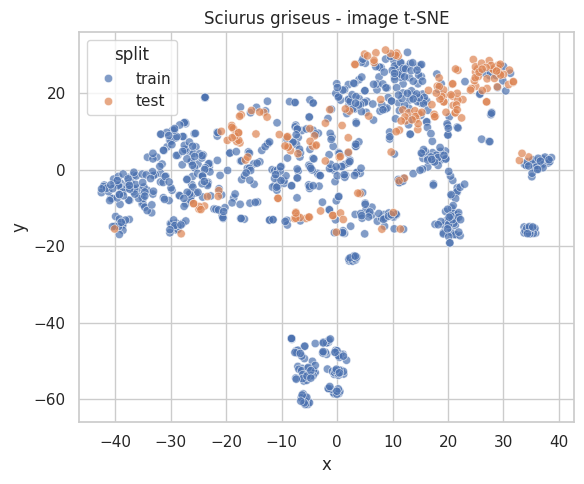

/data/vision/beery/scratch/timm/multimodal_occupancy/figures/domain_shift/tsne_sciurus_griseus_image.png


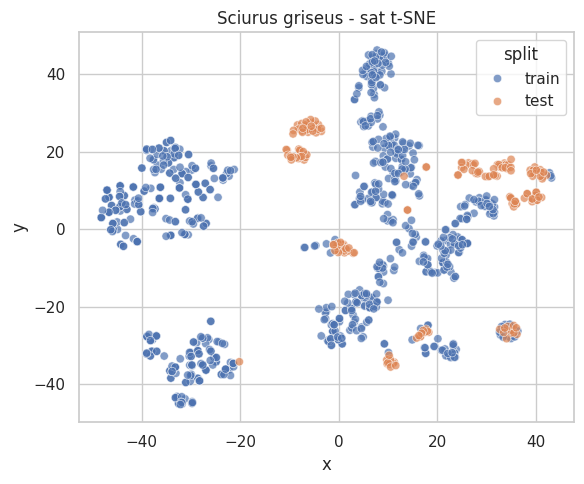

/data/vision/beery/scratch/timm/multimodal_occupancy/figures/domain_shift/tsne_sciurus_griseus_sat.png


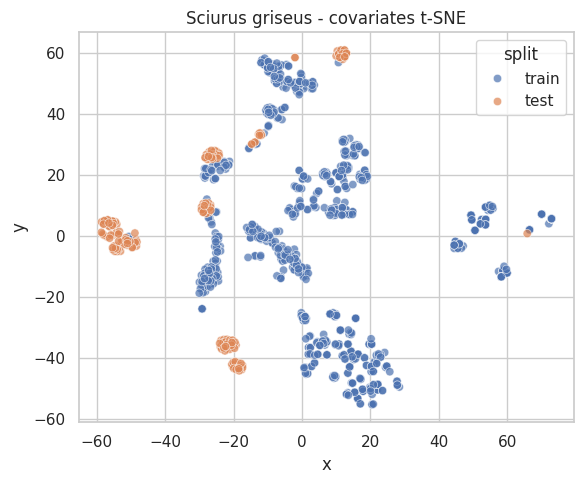

/data/vision/beery/scratch/timm/multimodal_occupancy/figures/domain_shift/tsne_sciurus_griseus_covariates.png


In [5]:
modalities_for_tsne = ["image", "sat", "covariates"]
range_flag = bool(limit_to_range)
base_data = prepare_base_data(set(modalities_for_tsne), apply_range_filter=range_flag)

top_species = (
    metrics[metrics["modality"] == "image"].nlargest(3, "mmd_rbf")["taxon_id"].unique()
)


def slugify(text: str) -> str:
    return "".join(ch.lower() if ch.isalnum() else "_" for ch in text).strip("_")


for taxon_id in top_species:
    info = get_split_features(
        base_data, taxon_id, modalities_for_tsne, apply_range=range_flag
    )
    if info is None:
        continue
    name = info["scientific_name"] or info["common_name"]
    slug = slugify(name or taxon_id)
    for modality in modalities_for_tsne:
        train, test = info["splits"][modality]
        if train.size == 0 or test.size == 0:
            continue
        tsne_df = run_tsne(
            train, test, max_samples=800, pca_components=50, random_state=0
        )
        plt.figure(figsize=(6, 5))
        sns.scatterplot(data=tsne_df, x="x", y="y", hue="split", alpha=0.7)
        plt.title(f"{name} - {modality} t-SNE")
        plt.tight_layout()
        out_path = fig_dir / f"tsne_{slug}_{modality}.png"
        plt.savefig(out_path, dpi=200)
        plt.show()
        plt.close()
        print(out_path)

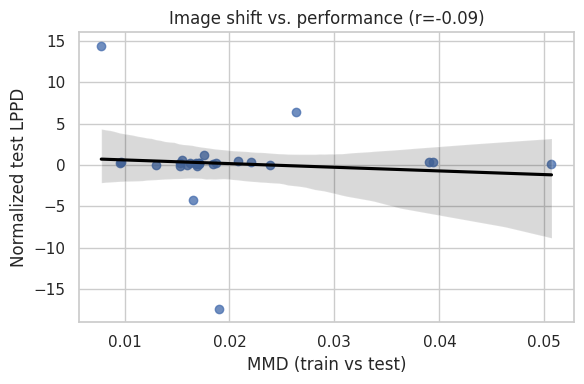

image saved to /data/vision/beery/scratch/timm/multimodal_occupancy/figures/domain_shift/shift_vs_lppd_image.png


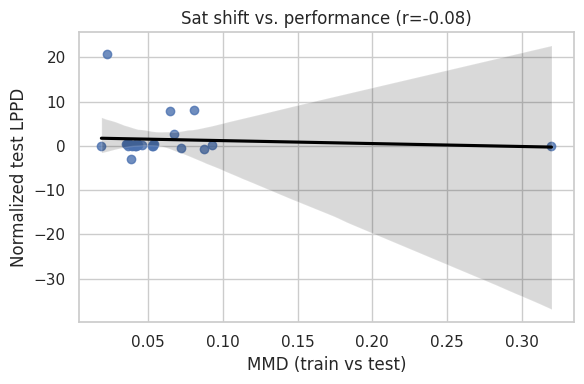

sat saved to /data/vision/beery/scratch/timm/multimodal_occupancy/figures/domain_shift/shift_vs_lppd_sat.png


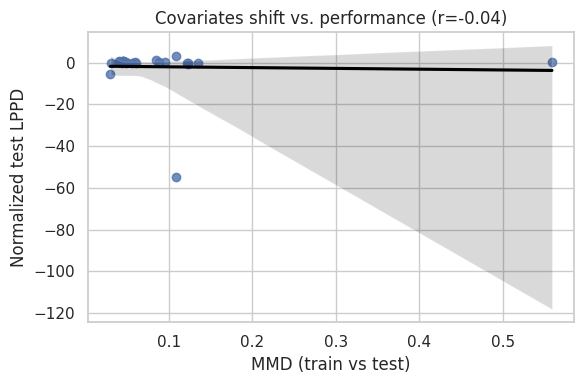

covariates saved to /data/vision/beery/scratch/timm/multimodal_occupancy/figures/domain_shift/shift_vs_lppd_covariates.png


In [6]:
import pickle

# Load performance metrics and compute normalized test LPPD
figure_df = pickle.load(open(cache_path / "figure_data.pkl", "rb"))


def compute_lppd_norm(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    denom = df["lppd_oracle_test"] - df["lppd_null_test"]
    df["lppd_test_norm"] = (df["lppd_test"] - df["lppd_null_test"]) / denom.replace(
        0, np.nan
    )
    return df


single_modality_perf = {
    "image": figure_df[
        (figure_df["modalities"].apply(lambda m: m == ["image"]))
        & (figure_df["image_backbone"] == default_image_backbone)
    ],
    "sat": figure_df[
        (figure_df["modalities"].apply(lambda m: m == ["sat"]))
        & (figure_df["sat_backbone"] == default_sat_backbone)
    ],
    "covariates": figure_df[
        figure_df["modalities"].apply(lambda m: m == ["covariates"])
    ],
}

for mod, perf_df in single_modality_perf.items():
    perf_df = compute_lppd_norm(perf_df)
    merged = metrics[metrics["modality"] == mod].merge(
        perf_df[["taxon_id", "lppd_test_norm"]], on="taxon_id", how="inner"
    )
    corr = merged[["mmd_rbf", "lppd_test_norm"]].corr().iloc[0, 1]
    plt.figure(figsize=(6, 4))
    sns.regplot(
        data=merged,
        x="mmd_rbf",
        y="lppd_test_norm",
        scatter_kws={"alpha": 0.8},
        line_kws={"color": "black"},
    )
    plt.title(f"{mod.capitalize()} shift vs. performance (r={corr:.2f})")
    plt.xlabel("MMD (train vs test)")
    plt.ylabel("Normalized test LPPD")
    plt.tight_layout()
    out_path = fig_dir / f"shift_vs_lppd_{mod}.png"
    plt.savefig(out_path, dpi=200)
    plt.show()
    plt.close()
    print(mod, "saved to", out_path)